In [ ]:
# connexion a l'espace Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# charger les bases de donnees depuis l'espace Drive
from zipfile import ZipFile
!unzip "/content/drive/MyDrive/PFE/Projet_photo.zip"
!unzip '/content/drive/MyDrive/PFE/Photo_test.zip'

In [ ]:
# import de library 
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
 
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
img_width, img_height = 224, 224  # taille d'image
FC_SIZE = 1024             # nombre de noede de fully connected
nb_classes = 5             # nombre de classe
nb_epoch = 30             # nombre d'epochs
batch_size = 32            # batch size

# path de base de donnees
pathphoto="Projet_photo"
testpath='/content/Photo_test'

#generalisation des donnees de l'apprentissage, de la validation et du test
image_generator = ImageDataGenerator(rescale=1/255,
                    horizontal_flip=True,
                    validation_split=0.1) 

train_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                            directory=pathphoto,
                            shuffle=True,
                            target_size=(img_height, img_width), 
                            subset="training")

validation_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                directory=pathphoto,
                                shuffle=True,
                                target_size=(img_height, img_width), 
                                subset="validation")

image_gen = ImageDataGenerator(rescale=1/255) 
test_dataset = image_gen.flow_from_directory(batch_size=batch_size,
                            directory=testpath,
                            shuffle=True,
                            target_size=(img_height, img_width), 
                            subset="training")

Found 460 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 370 images belonging to 5 classes.


In [ ]:
# creation de model
def create_model(nb_classes=5):
  input_shape = (224, 224, 3)
  inputs = Input(shape=input_shape)
  pretrained_model = InceptionV3(weights='imagenet', include_top=False)
  x = pretrained_model(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) # nouveau couche de FC
  x = BatchNormalization(momentum=0.9,epsilon=0.0001)(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization(momentum=0.9,epsilon=0.0001)(x)
  x = Dropout(0.5)(x)
  outputs = Dense(nb_classes, activation='sigmoid')(x)

  model = Model(inputs, outputs)
  return model

In [ ]:
model=create_model()

In [ ]:
model.layers[1].trainable = False # mettre la couche de inception v3 non-entrainable
print("-------------------------------------------------")
for layer in model.layers:
    print(layer.name, ' is trainable? ', layer.trainable)

-------------------------------------------------
input_1  is trainable?  True
inception_v3  is trainable?  False
global_average_pooling2d  is trainable?  True
dense  is trainable?  True
batch_normalization_94  is trainable?  True
dropout  is trainable?  True
dense_1  is trainable?  True
batch_normalization_95  is trainable?  True
dropout_1  is trainable?  True
dense_2  is trainable?  True


In [ ]:
opt = SGD(learning_rate=0.0001, momentum=0.9) #utiliser sgd pour l'optimization
model.compile(optimizer=opt,
      loss="categorical_crossentropy",
      metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_94 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Epoch 1/100
15/15 [==============================] - 8s 208ms/step - loss: 2.5426 - accuracy: 0.2522 - val_loss: 1.6318 - val_accuracy: 0.2400
Epoch 2/100
15/15 [==============================] - 1s 88ms/step - loss: 2.4030 - accuracy: 0.2435 - val_loss: 1.4746 - val_accuracy: 0.3400
Epoch 3/100
15/15 [==============================] - 1s 89ms/step - loss: 1.9737 - accuracy: 0.3239 - val_loss: 1.3516 - val_accuracy: 0.4000
Epoch 4/100
15/15 [==============================] - 1s 89ms/step - loss: 1.8590 - accuracy: 0.3891 - val_loss: 1.1811 - val_accuracy: 0.5400
Epoch 5/100
15/15 [==============================] - 1s 88ms/step - loss: 1.5757 - accuracy: 0.4326 - val_loss: 1.0846 - val_accuracy: 0.5800
Epoch 6/100
15/15 [==============================] - 1s 88ms/step - loss: 1.3955 - accuracy: 0.5000 - val_loss: 0.9661 - val_accuracy: 0.6200
Epoch 7/100
15/15 [==============================] - 1s 88ms/step - loss: 1.3614 - accuracy: 0.4978 - val_loss: 0.9340 - val_accuracy: 0.6200
Epoch

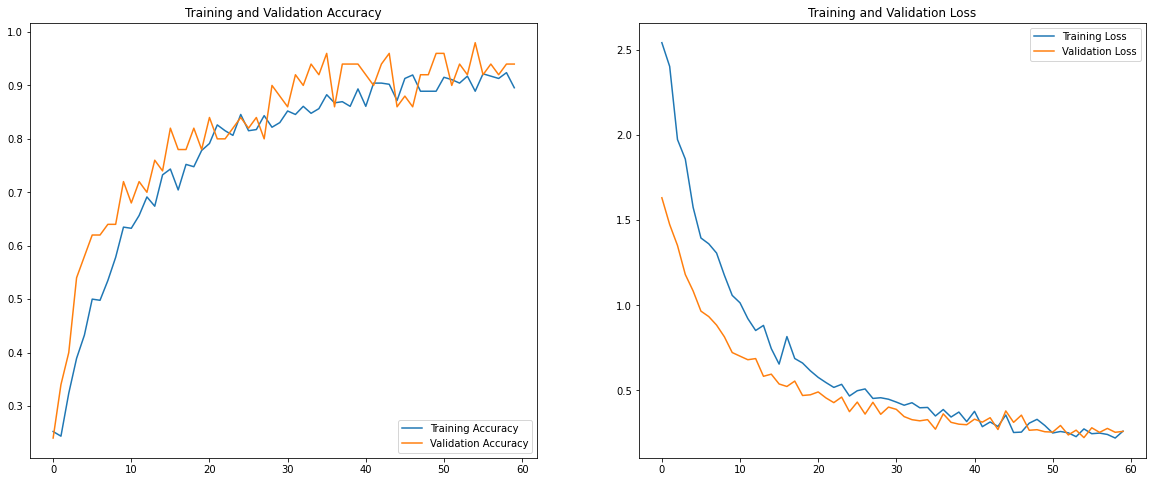

In [ ]:
epochs=60
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc[:epochs], label='Training Accuracy')
plt.plot(val_acc[:epochs], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss[:epochs], label='Training Loss')
plt.plot(val_loss[:epochs], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_dataset)

12/12 [==============================] - 1s 71ms/step - loss: 0.6203 - accuracy: 0.8054


[0.6203057169914246, 0.8054053783416748]

In [ ]:
model.save('/content/drive/MyDrive/PFE/model_inception_v3/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PFE/model_inception_v3/assets
